In [1]:
 !pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import pandas as pd
from google.colab import drive
import torch
from torch import nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from torchmetrics.functional import mean_absolute_percentage_error
from torchmetrics.functional import mean_squared_error

In [3]:
# Mount drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/ECSE-552/HW4"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset 

In [4]:
# Number of last measurement to take in consideration
k=4

In [5]:
class ForecastDataset(Dataset):
    def __init__(self, dataset_path, k=k, features=["p (mbar)", "T (degC)", "rh (%)", "wv (m/s)", "hour_sin","hour_cos","day_sin","day_cos"], targets=["p (mbar)", "T (degC)", "rh (%)", "wv (m/s)"]):
      """
      Parameters:
        features: list containing the name of the input features
      """
      # Dataset path
      self.dataset_path = dataset_path
      # Load the dataset
      self.df = pd.read_csv(dataset_path)
      # Number of time steps to take in consideration
      self.k = k
      # List of features
      self.features = features
      # List of target
      self.targets = targets
      # Data (X)
      self.X =  torch.tensor(self.df[self.features].values)
      # Targets (Y)
      self.Y = torch.tensor(self.df[self.targets].values)

    def get_data(self):
      '''
        Get data vector X
      '''
      return self.X

    def get_targets(self):
      '''
        Get label vector Y
      '''
      return self.Y


    def __len__(self):
      '''
        The len our dataset is calculated dividing the number of time measurement
        by the number of times steps + 1 (we need to take in account that the label is always the k + 1 sample)
      '''
      return len(self.X) - (self.k + 1)

    def __getitem__(self, idx):
      # Start index of the time series
      start_idx = idx
      # End index calculated as current idx + time steps
      end_idx = idx + self.k
      # Get data and targets
      x = self.X[start_idx:end_idx]
      # The target index is equal to end_idx
      y = self.Y[end_idx]
      return x, y

In [6]:
# Datasets names

# Original datasets 
train_dataset_name = "weather_train.csv"
test_dataset_name = "weather_test.csv"
# Normalized version of the original
train_norm_dataset_name = "weather_train_norm.csv"
test_norm_dataset_name = "weather_test_norm.csv"

# Train and validation split
train_split_dataset_name = "weather_train_split.csv"
val_dataset_name = "weather_val.csv"

# Datasets with time features
train_time_dataset_name = "weather_train_time.csv"
val_time_dataset_name = "weather_val_time.csv"
test_time_dataset_name = "weather_test_time.csv"



# Datasets paths
train_dataset_path = os.path.join(path, train_dataset_name)
test_dataset_path = os.path.join(path, test_dataset_name)

train_norm_dataset_path = os.path.join(path, train_norm_dataset_name)
test_norm_dataset_path = os.path.join(path, test_norm_dataset_name)

val_dataset_path = os.path.join(path, val_dataset_name)
train_split_dataset_path = os.path.join(path, train_split_dataset_name)

train_time_dataset_path = os.path.join(path, train_time_dataset_name)
val_time_dataset_path = os.path.join(path, val_time_dataset_name)
test_time_dataset_path = os.path.join(path, test_time_dataset_name)

In [7]:
# Create train dataset
train_dataset = ForecastDataset(train_time_dataset_path)
X_train = train_dataset.get_data()
Y_train = train_dataset.get_targets()

# Shape of our dataset
print("X shape: ", X_train.shape)
print("Y shape: ", Y_train.shape)

X shape:  torch.Size([252300, 8])
Y shape:  torch.Size([252300, 4])


In [8]:
# Create validation dataset
val_dataset = ForecastDataset(val_time_dataset_path)
X_val = val_dataset.get_data()
Y_val = val_dataset.get_targets()

# Shape of our dataset
print("X shape: ", X_val.shape)
print("Y shape: ", Y_val.shape)

X shape:  torch.Size([28035, 8])
Y shape:  torch.Size([28035, 4])


In [9]:
# Create test dataset

test_dataset = ForecastDataset(test_time_dataset_path)
X_test = test_dataset.get_data()
Y_test = test_dataset.get_targets()

# Shape of our dataset
print("X shape: ", X_test.shape)
print("Y shape: ", Y_test.shape)

X shape:  torch.Size([14019, 8])
Y shape:  torch.Size([14019, 4])


In [10]:
batch_size = 50

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [11]:
for x,y in train_loader:
  print(x.shape)
  print(y.shape)
  break

torch.Size([50, 4, 8])
torch.Size([50, 4])


## Dataset with time values

In [ ]:
import numpy as np
from datetime import datetime
def discretize_date(current_date, t):
    current_date = current_date
    cdate = datetime.strptime(current_date, '%d.%m.%Y %H:%M:%S')
    if t == 'hour_sin':
        return np.sin(2 * np.pi * cdate.hour/24.0)
    if t == 'hour_cos':
        return np.cos(2 * np.pi * cdate.hour/24.0)
    if t == 'day_sin':
        return np.sin(2 * np.pi * cdate.timetuple().tm_yday/365.0)
    if t == 'day_cos':
        return np.cos(2 * np.pi * cdate.timetuple().tm_yday/365.0)

In [ ]:
def datetime_preprocessing(df):
  date_types = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']
  for dt in date_types:
      df[dt] = df['Date Time'].apply(lambda x : discretize_date(x, dt))
  df.drop(['Date Time'],axis=1,inplace=True)

In [ ]:
# Read the datasets:
train_time = pd.read_csv(train_split_dataset_path)
val_time = pd.read_csv(val_dataset_path)
test_time = pd.read_csv(test_norm_dataset_path)


datetime_preprocessing(train_time)
datetime_preprocessing(val_time)
datetime_preprocessing(test_time)


In [ ]:
# Save datasets
train_time.to_csv(train_time_dataset_path)
val_time.to_csv(val_time_dataset_path)
test_time.to_csv(test_time_dataset_path)

## Normalize dataset 

In [ ]:
# Read train csv
train_df = pd.read_csv(train_dataset_path)
test_df = pd.read_csv(test_dataset_path)

train_norm = train_df.copy()
test_norm = test_df.copy()

In [ ]:
columns_to_normalize = ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 
                        'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)',
                        'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)'] 


medians = train_df.quantile(q=0.5, axis=0)
percentiles_high = train_df.quantile(q=0.99, axis=0)
percentiles_low = train_df.quantile(q=0.01, axis=0)


for col in columns_to_normalize:
  train_norm[col] = (train_df[col] - medians[col]) / (percentiles_high[col]-percentiles_low[col]) * 2
  test_norm[col] = (test_df[col] - medians[col]) / (percentiles_high[col]-percentiles_low[col]) * 2

<ipython-input-12-7e4844bdddd4>:6: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  medians = train_df.quantile(q=0.5, axis=0)
<ipython-input-12-7e4844bdddd4>:7: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  percentiles_high = train_df.quantile(q=0.99, axis=0)
<ipython-input-12-7e4844bdddd4>:8: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  percentiles_low = train_df.quantile(q=0.01, axis=0)


In [ ]:
train_norm.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 01:00:00,0.354529,-0.885336,-0.900340,-0.872862,0.461872,-0.474555,-0.607602,-0.177156,-0.606172,-0.609366,0.995663,-0.448227,-0.452165,-0.027146
1,01.01.2009 02:00:00,0.360389,-0.928510,-0.943020,-0.936754,0.424675,-0.486798,-0.634433,-0.175291,-0.632528,-0.635813,1.042657,-0.436879,-0.452165,-0.041008
2,01.01.2009 03:00:00,0.371132,-0.924869,-0.940479,-0.929655,0.433974,-0.486215,-0.631079,-0.176224,-0.629014,-0.632507,1.041908,-0.456738,-0.452165,-0.174429
3,01.01.2009 04:00:00,0.378457,-0.937353,-0.953182,-0.952888,0.406076,-0.489713,-0.640022,-0.173427,-0.637799,-0.642424,1.057216,-0.479433,-0.499862,0.246049
4,01.01.2009 05:00:00,0.401408,-0.967523,-0.984684,-0.993546,0.393676,-0.497292,-0.655674,-0.173427,-0.653612,-0.657851,1.095540,-0.394326,-0.404468,-0.233343


In [ ]:
# Save the normalized dataset
train_norm.to_csv(train_norm_dataset_path)
test_norm.to_csv(test_norm_dataset_path)

## Generate validation dataset
Run this code only if you want to regenerate the train and validation

In [ ]:
# Read train csv
df = pd.read_csv(train_norm_dataset_path)
# Validation len
n_val = int(len(df.index) * 0.1)
# Last index that can be used
end_idx = len(df.index) - (k + 1)
# Generate random indexlen(df.index
indices = np.arange(0, end_idx)
np.random.shuffle(indices)
val_indices = indices[:n_val]
train_indices = indices[n_val:]

In [ ]:
columns = {column: [] for column in df.columns }
val_df = pd.DataFrame(data=columns)
train_df = pd.DataFrame(data=columns)

for index in val_indices:
  val_df = pd.concat([val_df, df.iloc[index:index+k+1]])
for index in train_indices:
  train_df = pd.concat([train_df, df.iloc[index:index+k+1]])

In [ ]:
# Save validation datasets
val_df.to_csv(val_dataset_path)
# Save train datasets
train_df.to_csv(train_split_dataset_path) 

# Models

The models implemented are the following:
- A baseline model consisting of only fully-connected (nn.Linear) layers
- A baseline model that uses at least one layer of LSTM
- Your own model (may use any neural network, including but not limited to CNNs and GRUs)

More information about the models can be found in the corresponding sections

## Fully-connected baseline

In [12]:
class fully_connected_baseline(nn.Module):

    def __init__(self, n_features, n_outputs):
      super(fully_connected_baseline, self).__init__()
      self.n_features = n_features
      self.n_outputs = n_outputs
      layers = []
      layers.append(nn.Linear(n_features*k, n_features**2))
      layers.append(nn.ReLU())
      layers.append(nn.Linear(n_features**2, n_features**2))
      layers.append(nn.ReLU())
      layers.append(nn.Linear(n_features**2, n_features**2))
      layers.append(nn.ReLU())
      layers.append(nn.Linear(n_features**2, n_features**2))
      layers.append(nn.ReLU())
      layers.append(nn.Linear(n_features**2, n_features**2))
      layers.append(nn.ReLU())
      layers.append(nn.Linear(n_features**2, n_features**2))
      layers.append(nn.ReLU())
      layers.append(nn.Linear(n_features**2, n_outputs**2))
      layers.append(nn.ReLU())
      layers.append(nn.Linear(n_outputs**2, n_outputs**2))
      layers.append(nn.ReLU())
      layers.append(nn.Linear(n_outputs**2, n_outputs))
      #layers.append(nn.Tanh())
      self.all_layers = nn.Sequential(*layers)

    def forward(self, x):
        out = self.all_layers(x)
        return out


In [13]:
USE_CUDA = torch.cuda.is_available()
device = 'cuda' if USE_CUDA else 'cpu'
model = fully_connected_baseline(8,4).to(device).type(torch.float32)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
n_epochs = 20


In [14]:
# Lists to store training and validation losses
t_losses_mlp, v_losses_mlp = [], []
t_mape_mlp , v_mape_mlp = [], []
# Loop over epochs
for epoch in range(n_epochs):
  train_loss, valid_loss = 0.0, 0.0
  mape_train, mape_val = 0.0, 0.0

  # train step
  model.train()
  # Loop over train dataset
  for x, y in train_loader:
    optimizer.zero_grad()
    # move inputs to device
    x = x.to(device)
    x = x.type(torch.float32)
    y  = y.squeeze().to(device).type(torch.float32)
    # Forward Pass
    preds = model(x.flatten(start_dim = 1)).squeeze()
    loss = criterion(preds, y) # compute batch loss
    train_loss += loss.item()
    loss.backward()
    optimizer.step()
    mape_train += mean_absolute_percentage_error(preds, y)
  epoch_loss = train_loss / len(train_loader)
  t_losses_mlp.append(epoch_loss)

  
  # validation step
  model.eval()
  # Loop over validation dataset
  for x, y in val_loader:
    with torch.no_grad():
      x, y = x.to(device).type(torch.float32), y.squeeze().to(device).type(torch.float32)
      preds = model(x.flatten(start_dim = 1)).squeeze()
      error = criterion(preds, y)
      # print(error)
    valid_loss += error.item()
    mape_val += mean_absolute_percentage_error(preds, y)
  valid_loss = valid_loss / len(test_loader)
  v_losses_mlp.append(valid_loss)

  t_mape_mlp.append(mape_val / len(val_loader))
  v_mape_mlp.append(mape_train/len(train_loader))


      
  print(f'{epoch} - train: {epoch_loss}, valid: {valid_loss}, mape train: {t_mape_mlp[-1]}, mape val: {v_mape_mlp[-1]}')

0 - train: 0.10070369661489374, valid: 0.1622049260618431, mape train: 175.142578125, mape val: 177.39239501953125
1 - train: 0.07914137917693531, valid: 0.1542805526671665, mape train: 165.35427856445312, mape val: 149.13592529296875
2 - train: 0.07754515679507, valid: 0.15372158149257303, mape train: 168.8848114013672, mape val: 143.0209503173828
3 - train: 0.07712002095680526, valid: 0.15312380907791, mape train: 156.51182556152344, mape val: 144.0819854736328
4 - train: 0.07679316355884666, valid: 0.1521338286676577, mape train: 163.51463317871094, mape val: 139.5484619140625
5 - train: 0.07658546130007689, valid: 0.15337637636278356, mape train: 151.38388061523438, mape val: 140.59378051757812
6 - train: 0.07637844779653284, valid: 0.15097271500022283, mape train: 158.47731018066406, mape val: 140.10733032226562
7 - train: 0.0762647402527252, valid: 0.15217555068832422, mape train: 158.9427947998047, mape val: 139.38157653808594
8 - train: 0.07615456273862345, valid: 0.15201458655

In [15]:
t_mape_mlp = [x.cpu().detach().numpy() for x in t_mape_mlp] 
v_mape_mlp = [x.cpu().detach().numpy() for x in v_mape_mlp] 

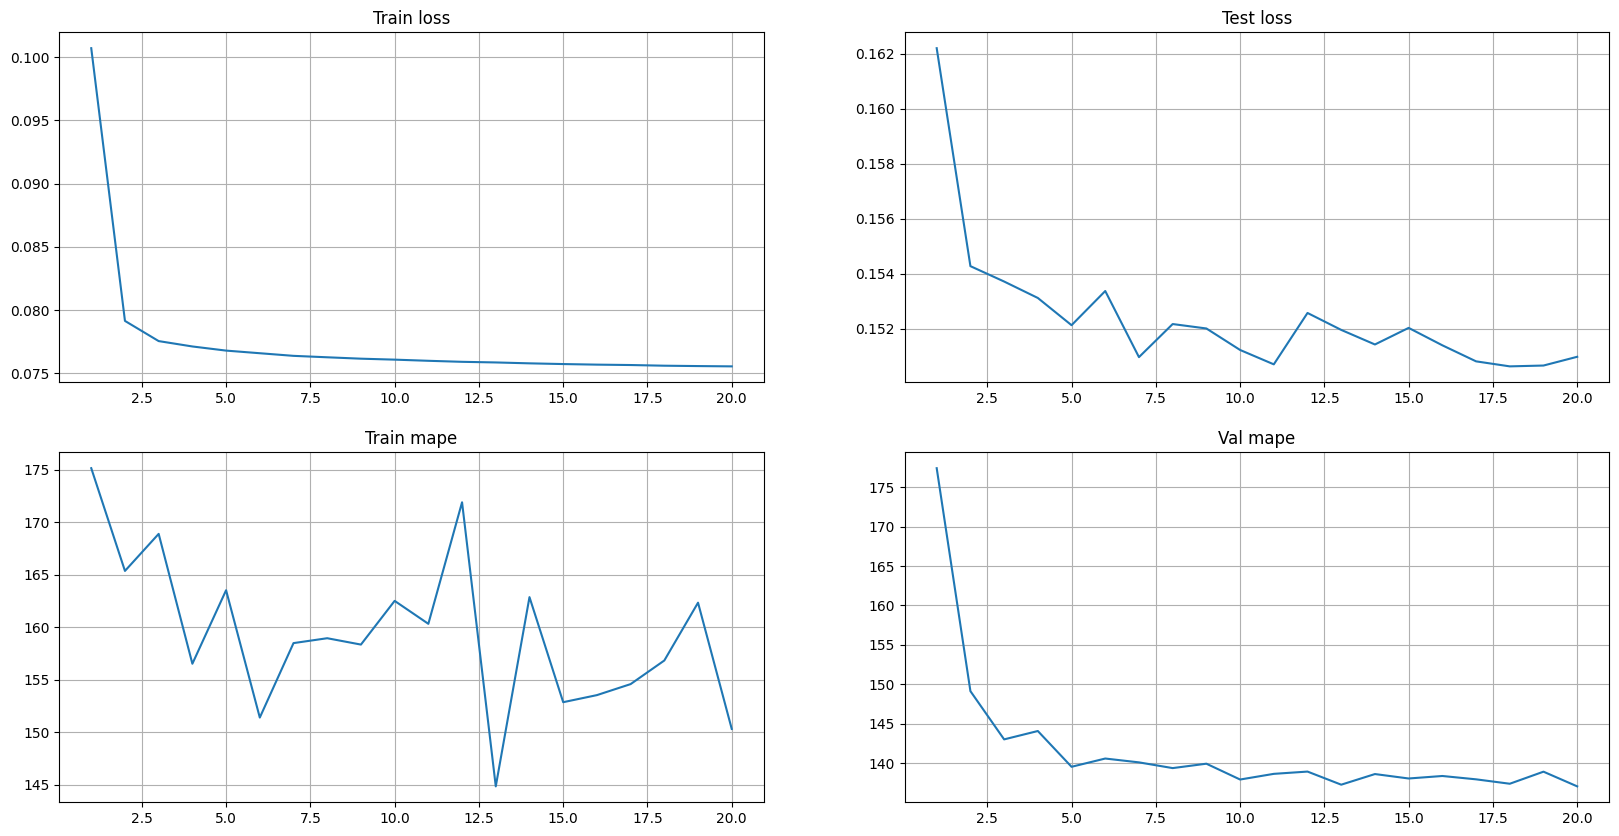

In [16]:
x_axis = np.arange(1, n_epochs+1)

plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title("Train loss")
plt.grid()
plt.plot(x_axis, t_losses_mlp)
plt.subplot(222)
plt.grid()
plt.title("Test loss")
plt.plot(x_axis, v_losses_mlp)
plt.subplot(223)
plt.grid()
plt.title("Train mape")
plt.plot(x_axis, t_mape_mlp)
plt.subplot(224)
plt.grid()
plt.title("Val mape")
plt.plot(x_axis, v_mape_mlp)

## Baseline with at least one layer of LSTM

In [17]:
class LSTMForecaster(nn.Module):


  def __init__(self, n_features, n_hidden, n_outputs, sequence_len, num_lstm_layers=1, use_cuda=False, dropout=0.3):
    '''
    n_features: number of input features
    n_hidden: number of neurons in each hidden layer
    n_outputs: number of outputs to predict for each training example
    n_deep_layers: number of hidden dense layers after the lstm layer
    sequence_len: number of steps to look back at for prediction
    dropout: float (0 < dropout < 1) dropout ratio between dense layers
    '''
    super().__init__()

    self.num_lstm_layers = num_lstm_layers
    self.nhid = n_hidden
    self.use_cuda = use_cuda
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
    device = 'cuda' if self.use_cuda else 'cpu'
    # LSTM Layer
    self.lstm = nn.LSTM(n_features,
                        n_hidden,
                        num_layers=num_lstm_layers,
                        batch_first=True).to(device) # As we have transformed our data in this way
    
    # first dense after lstm
    self.fc1 = nn.Linear(n_hidden * sequence_len, n_hidden) 
    # Dropout layer 
    self.dropout = nn.Dropout(p=dropout)
    self.fc2 = nn.Linear(n_hidden , n_hidden*3) 

    self.fc3 = nn.Linear(n_hidden*3, n_hidden*2) 
    self.fc4 = nn.Linear(n_hidden*2, n_hidden*2) 
    self.fc5 = nn.Linear(n_hidden*2, n_hidden) 
    self.fc6 = nn.Linear(n_hidden, n_outputs) 


  def forward(self, x):

    device = 'cuda' if self.use_cuda else 'cpu'
    # Initialize hidden state
    hidden_state = torch.zeros(self.num_lstm_layers, x.shape[0], self.nhid).to(device)
    cell_state = torch.zeros(self.num_lstm_layers, x.shape[0], self.nhid).to(device)
        
    self.hidden = (hidden_state, cell_state)

    # Forward Pass
    x, h = self.lstm(x, self.hidden) 
    x = self.dropout(x.contiguous().view(x.shape[0], -1)) 
    x = self.fc1(x) # First Dense
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc4(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc5(x)
    x = self.relu(x)
    x = self.fc6(x)
    #x = self.tanh(x)
    return x
    # self.dnn(x) # Pass forward through fully connected DNN.

In [18]:
nhid = 30 # Number of nodes in the hidden layer
# n_dnn_layers = 5 # Number of hidden fully connected layers
nout = 4 # Prediction Window
sequence_len = k # Training Window

# Number of features (since this is a univariate timeseries we'll set
# this to 1 -- multivariate analysis is coming in the future)
ninp = 8

# Device selection (CPU | GPU)
USE_CUDA = torch.cuda.is_available()
device = 'cuda' if USE_CUDA else 'cpu'

# Initialize the model
model_lstm = LSTMForecaster(ninp, nhid, nout, sequence_len, num_lstm_layers=3 ,use_cuda=USE_CUDA).to(device)
model_lstm = model_lstm.type(torch.float32).to(device)

In [19]:
# Set learning rate and number of epochs to train over
lr = 4e-4
n_epochs = 20

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model_lstm.parameters(), lr=lr)


In [20]:
# Lists to store training and validation losses
t_losses_lstm, v_losses_lstm = [], []
t_mape_lstm , v_mape_lstm = [], []

# Loop over epochs
for epoch in range(n_epochs):
  train_loss, valid_loss = 0.0, 0.0
  mape_train, mape_val = 0.0, 0.0


  # train step
  model_lstm.train()
  # Loop over train dataset
  for x, y in train_loader:
    optimizer.zero_grad()
    # move inputs to device
    x = x.to(device)
    x = x.type(torch.float32)
    y  = y.squeeze().to(device).type(torch.float32)
    # Forward Pass
    preds = model_lstm(x).squeeze()
    loss = criterion(preds, y) # compute batch loss
    train_loss += loss.item()
    loss.backward()
    optimizer.step()
    mape_train += mean_absolute_percentage_error(preds, y)
  epoch_loss = train_loss / len(train_loader)
  t_losses_lstm.append(epoch_loss)
  
  # validation step
  model_lstm.eval()
  # Loop over validation dataset
  for x, y in val_loader:
    with torch.no_grad():
      x, y = x.to(device).type(torch.float32), y.squeeze().to(device).type(torch.float32)
      preds = model_lstm(x).squeeze()
      error = criterion(preds, y)
      mape_val += mean_absolute_percentage_error(preds, y)
    valid_loss += error.item()
    # print(valid_loss)
  valid_loss = valid_loss / len(val_loader)
  v_losses_lstm.append(valid_loss)

  t_mape_lstm.append(mape_val / len(val_loader))
  v_mape_lstm.append(mape_train/len(train_loader))

      
  print(f'{epoch} - train: {epoch_loss}, valid: {valid_loss}, mape train: {t_mape_lstm[-1]}, mape val: {v_mape_lstm[-1]}')# plot_losses(t_losses, v_losses)

0 - train: 0.14665207270794983, valid: 0.13564161992232715, mape train: 213.5908966064453, mape val: 180.55844116210938
1 - train: 0.1162254781453945, valid: 0.10611897939816117, mape train: 169.0096893310547, mape val: 183.45460510253906
2 - train: 0.10850534349443655, valid: 0.10010804990971726, mape train: 185.80221557617188, mape val: 175.79293823242188
3 - train: 0.09918484556958508, valid: 0.09346900346156742, mape train: 174.43482971191406, mape val: 187.001708984375
4 - train: 0.09634027306887628, valid: 0.09207811158017389, mape train: 156.0205078125, mape val: 177.53375244140625
5 - train: 0.094933772686688, valid: 0.09266768946711507, mape train: 163.69287109375, mape val: 181.19627380371094
6 - train: 0.09405965861763779, valid: 0.09278883814279522, mape train: 166.76307678222656, mape val: 175.63853454589844
7 - train: 0.09320021166112662, valid: 0.09305096242044653, mape train: 158.49488830566406, mape val: 171.9095458984375
8 - train: 0.09265315363587899, valid: 0.090750

In [21]:
t_mape_lstm = [x.cpu().detach().numpy() for x in t_mape_lstm] 
v_mape_lstm = [x.cpu().detach().numpy() for x in v_mape_lstm] 

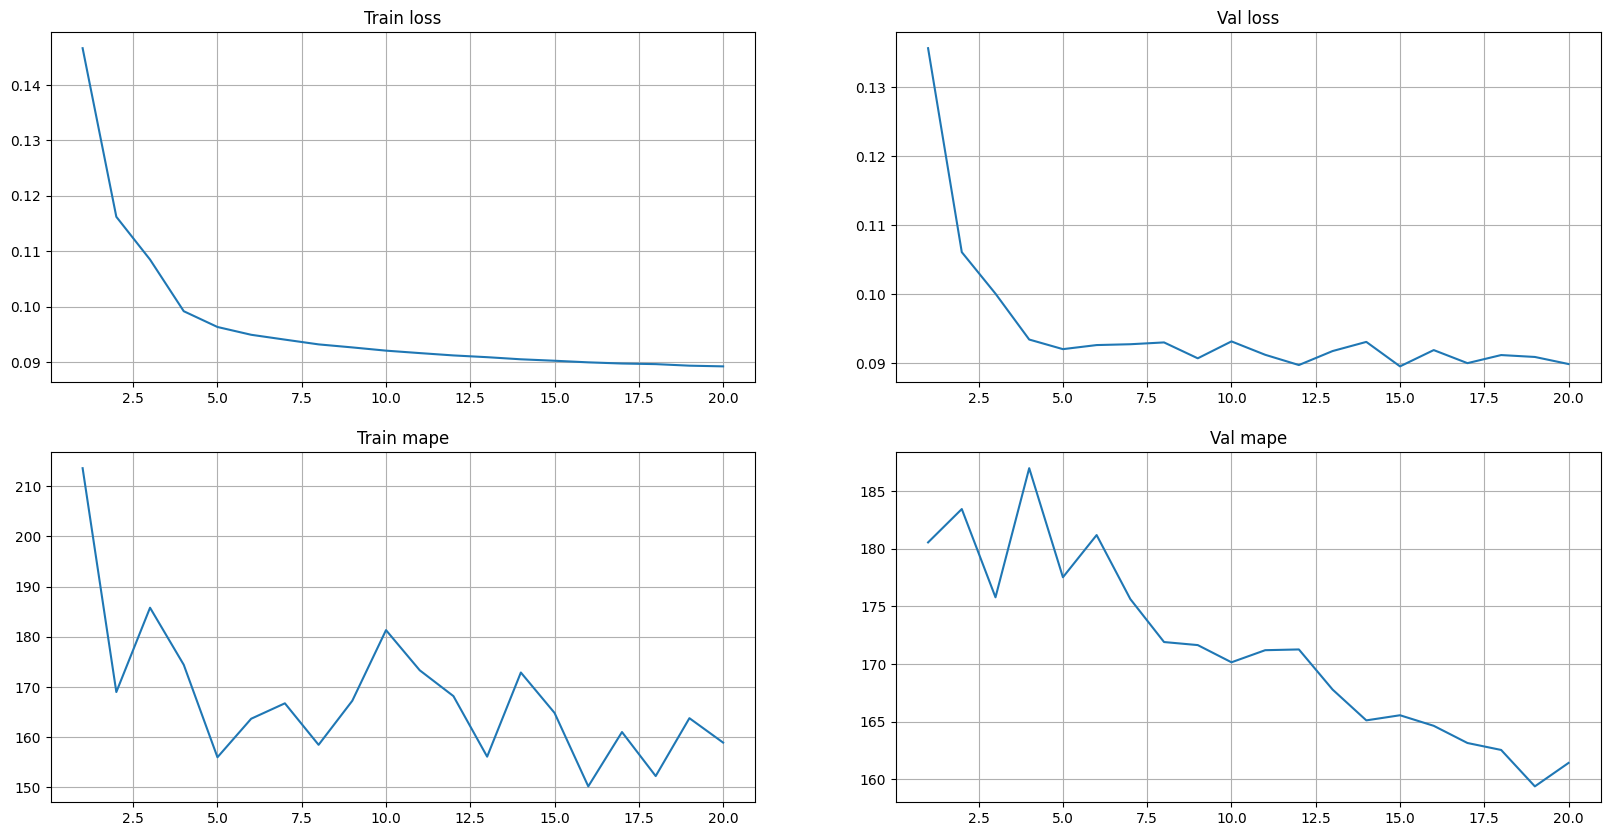

In [22]:
x_axis = np.arange(1, n_epochs+1)

plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title("Train loss")
plt.grid()
plt.plot(x_axis,t_losses_lstm)
plt.subplot(222)
plt.grid()
plt.title("Val loss")
plt.plot(x_axis, v_losses_lstm)
plt.subplot(223)
plt.grid()
plt.title("Train mape")
plt.plot(x_axis, t_mape_lstm)
plt.subplot(224)
plt.grid()
plt.title("Val mape")
plt.plot(x_axis, v_mape_lstm)

# Custom model

In [27]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

In [28]:
class CustomForecast(nn.Module):
  def __init__(self, in_size=4, output_size=4, hidden_size=10 ,activation=nn.ReLU(), loss=nn.MSELoss(), name="custom_forecaster", version=1):
    super(CustomForecast, self).__init__()

    # Name of the model
    self.name = name
    self.version = version
    self.in_size = in_size

    # Loss function
    self.loss = loss

    # CNN parameters
    self.in_channels = 1

    # Dropout
    p = 0.25
    dropout2d = nn.Dropout2d(p=p)

    self.activation = activation

    # Define the CNN model
    self.cnn = nn.Conv2d(in_channels=self.in_channels, out_channels=1, kernel_size=(2, 2))

    # GRU network
    self.gru_in = 7
    self.hidden_size = hidden_size
    self.num_layers = 4
    self.GRU = nn.GRU(self.gru_in, self.hidden_size, num_layers=self.num_layers, batch_first=True)
    
    self.out = nn.Linear(self.hidden_size, output_size)

  def forward(self, x):
    x1 = self.cnn(x)
    x1 = torch.squeeze(x1, dim=1)
    #print("x1 shape", x1.shape)
    x2, (h) = self.GRU(x1)
    #print(f"GRU out: {x2.shape}\t, hidden_state: {h.shape}")

    #print("X2 shape: ", x2.shape)
    h = self.activation(h[-1,:,:])
    output = self.out(h)

    return output

  def get_name(self):
    return self.name + "_" + str(self.version)



In [29]:
def training_loop(model, train_loader, val_loader, epochs, optimizer, loss, scheduler):
  train_losses = []
  val_losses = []

  train_mape_epoch = []
  val_mape_epoch = []
  for epoch in range(epochs):
    train_loss = 0.0
    mape_train = 0.0
    model.train()
    for x, y in train_loader:
      # Use GPU
      x = x.to(device)
      y = y.to(device)
      # Convert type
      x = x.type(torch.float32)
      y = y.type(torch.float32)

      x = torch.unsqueeze(x, dim=1)

      optimizer.zero_grad()
      #print(x.shape)

      y_hat = model(x)
     # print(f"y_hat: {y_hat.shape}\t y:{y.shape}")
      batch_loss = loss(y_hat, y)
      batch_loss.backward()
      optimizer.step()
      train_loss += batch_loss.item()
      mape_train += mean_absolute_percentage_error(y_hat, y)

    model.eval()
    with torch.no_grad():
      val_loss = 0.0
      val_mape = 0.0
      for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)
        # Convert type
        x = x.type(torch.float32)
        y = y.type(torch.float32)

        x = torch.unsqueeze(x, dim=1)

        y_hat = model(x)
        batch_loss = loss(y_hat, y)
        val_loss += batch_loss.item()
        val_mape += mean_absolute_percentage_error(y_hat, y)

    scheduler.step()
    train_losses.append(train_loss / len(train_loader))
    train_mape_epoch.append(mape_train / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_mape_epoch.append(val_mape / len(val_loader))
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Val Loss: {val_loss / len(val_loader)}\t\tTraining mape: {train_mape_epoch[-1]}\t\t Val mape: {val_mape_epoch[-1]}')
  return train_losses, val_losses, train_mape_epoch, val_mape_epoch

In [25]:
time_features=["p (mbar)", "T (degC)", "rh (%)", "wv (m/s)", "hour_sin", "hour_cos", "day_sin", "day_cos"]

# Load train
train_time_dataset = ForecastDataset(train_time_dataset_path, features=time_features)
# Load val
val_time_dataset = ForecastDataset(val_time_dataset_path, features=time_features)
# Load test
test_time_dataset = ForecastDataset(test_time_dataset_path, features=time_features)

batch_size = 50
# Create the dataloaders
train_time_loader = DataLoader(train_time_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
val_time_loader = DataLoader(val_time_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
test_time_loader = DataLoader(test_time_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [30]:
epochs = 20

custom_model = CustomForecast(in_size=len(time_features), hidden_size=40, name="custom_forecast_time")
custom_model.to(device)
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.001)
loss = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

TRAINING = False

save_path = os.path.join(path, "checkpoints", custom_model.get_name())

if TRAINING:
  train_losses, val_losses, train_mape, val_mape = training_loop(custom_model, train_time_loader, val_time_loader, epochs, optimizer, loss, scheduler)
  torch.save(custom_model.state_dict(), save_path)
  print("Model saved succesfully!")
else:
  custom_model.load_state_dict(torch.load(save_path))
  print("Model loaded succesfully!")

Model loaded succesfully!


In [56]:
train_mape = [x.cpu().detach().numpy() for x in train_mape] 
val_mape = [x.cpu().detach().numpy() for x in val_mape] 

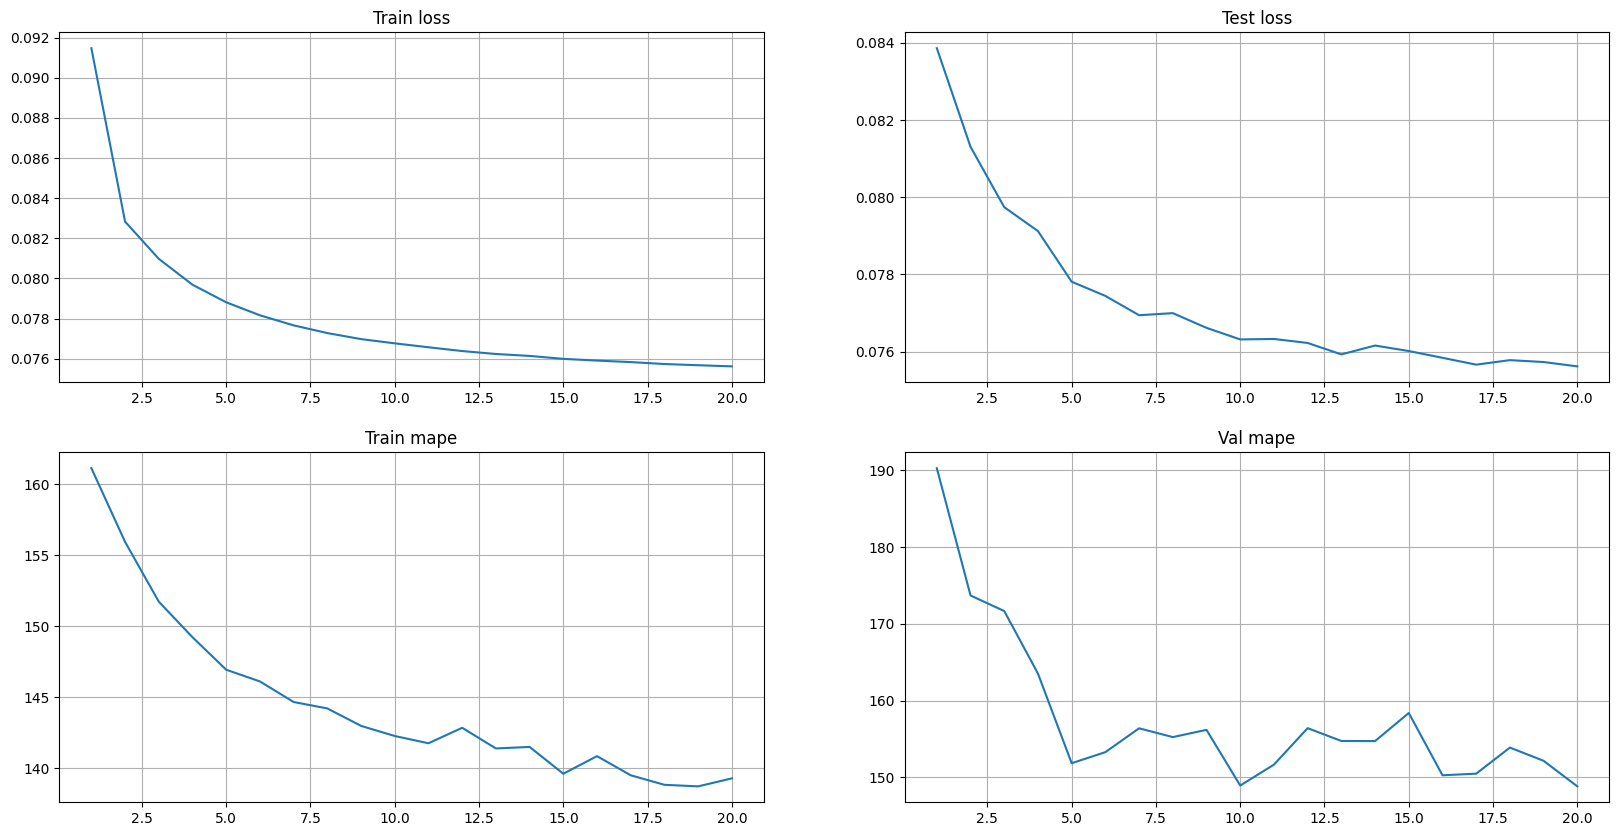

In [60]:
x_axis = np.arange(1, epochs+1, dtype=int)

plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title("Train loss")
plt.grid()
plt.plot(x_axis, train_losses)
plt.subplot(222)
plt.grid()
plt.title("Test loss")
plt.plot(x_axis, val_losses)
plt.subplot(223)
plt.grid()
plt.title("Train mape")
plt.plot(x_axis, train_mape)
plt.subplot(224)
plt.grid()
plt.title("Val mape")
plt.plot(x_axis, val_mape)


# Test data


In [31]:
def test_loop(model, test_loader, name="MLP"):
  p_test = 0.0
  t_test = 0.0
  rh_test = 0.0
  wv_test = 0.0

  test_mse = 0.0
  test_mape = 0.0

  model.eval()
  for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    # Convert type
    x = x.type(torch.float32)
    y = y.type(torch.float32)


    if name == "Custom":
      x = torch.unsqueeze(x, dim=1)
    elif name == "MLP":
      y  = y.squeeze().to(device).type(torch.float32)
      x = x.flatten(start_dim = 1)
    else:
       y  = y.squeeze().to(device).type(torch.float32)


    y_pred = model(x)

    p_test += mean_squared_error(y_pred[:, 0], y[:, 0])
    t_test += mean_squared_error(y_pred[:, 1], y[:, 1])
    rh_test += mean_squared_error(y_pred[:, 2], y[:, 2])
    wv_test += mean_squared_error(y_pred[:, 3], y[:, 3])
    #print(wv_test)


    test_mse += mean_squared_error(y_pred, y)
    test_mape += mean_absolute_percentage_error(y_pred, y)

  p_test = p_test / len(test_loader)
  t_test = t_test / len(test_loader)
  rh_test = rh_test / len(test_loader)
  wv_test = wv_test / len(test_loader)
  
  test_mse = test_mse / len(test_loader)
  test_mape = test_mape / len(test_loader)

  print("Model: ", name)
  print(f"Test MSE: {test_mse}, Test MAPE: {test_mape}, p test: {p_test}, t test: {t_test}, rh test: {rh_test}, wv test: {wv_test}")

  return test_mse, test_mape, p_test, t_test, rh_test, wv_test

In [32]:
# Test metrics for the MLP
test_mse_mlp, test_mape_mlp, p_test_mlp, t_test_mlp, rh_test_mlp, wv_test_mlp = test_loop(model, test_time_loader, name="MLP")
# Test metrics for LSTM
test_mse_lstm, test_mape_lstm, p_test_lstm, t_test_lstm, rh_test_lstm, wv_test_lstm = test_loop(model_lstm, test_time_loader, name="LSTM")
# Test metrics for custom
test_mse_custom, test_mape_custom, p_test_custom, t_test_custom, rh_test_custom, wv_test_custom = test_loop(custom_model, test_time_loader, name="Custom")

Model:  MLP
Test MSE: 398.07769775390625, Test MAPE: 76.22209930419922, p test: 9.636103630065918, t test: 9.312501907348633, rh test: 8.619361877441406, wv test: 1564.7430419921875
Model:  LSTM
Test MSE: 431.42779541015625, Test MAPE: 81.71560668945312, p test: 0.04661586508154869, t test: 0.06303492188453674, rh test: 0.09981060773134232, wv test: 1725.5030517578125
Model:  Custom
Test MSE: 431.2657775878906, Test MAPE: 77.42420196533203, p test: 0.03611083701252937, t test: 0.04492417350411415, rh test: 0.07204177975654602, wv test: 1724.91015625


# Error propagation

In [40]:
custom_model.eval()

with torch.no_grad():
  total_time = 100
  start_time = np.random.randint(low=0, high=len(test_time_dataset)-total_time)

  data = test_time_dataset.get_data()[:total_time]

  predictions = data[:k, :4].to(device)
  time_informations = data[:total_time, 4:].to(device)
  
  # First prediction
  x = predictions[-k:]
  x = torch.cat([x, time_informations[:k]], dim=1)
  x = x.unsqueeze(dim=0)
  x = x.unsqueeze(dim=1)
  x = x.type(torch.float32)
  x = x.to(device)
  prediction = custom_model(x)

  predictions = torch.cat([predictions, prediction], dim=0)
  for i in range(1, total_time-k):
    x = predictions[-k:]
    x = torch.cat([x, time_informations[i:k+i]], dim=1)
    x = x.unsqueeze(dim=0)
    x = x.unsqueeze(dim=1)
    x = x.type(torch.float32)
    x = x.to(device)
    prediction = custom_model(x)
    predictions = torch.cat([predictions, prediction], dim=0)

predictions = predictions.cpu().detach().numpy()
ground_truth = data

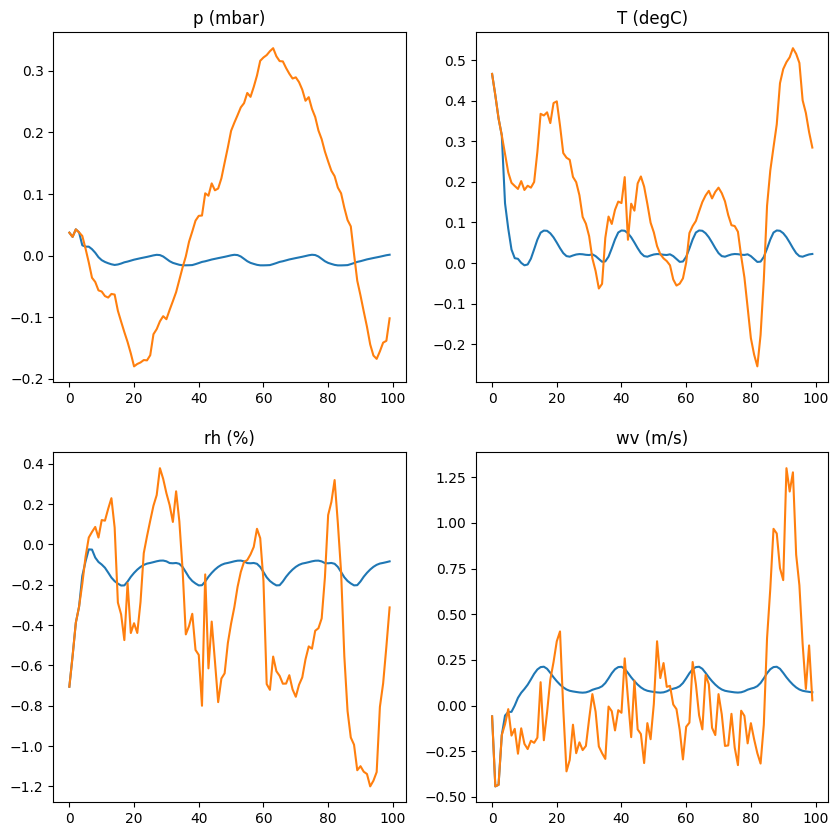

In [41]:
plt.figure(figsize=(10,10))
# Display errors
plt.subplot(221)    
plt.title("p (mbar)")
plt.plot(predictions[:, 0])
plt.plot(ground_truth[:, 0])
plt.subplot(222)
plt.title("T (degC)")
plt.plot(predictions[:, 1])
plt.plot(ground_truth[:, 1])
plt.subplot(223)
plt.title("rh (%)")
plt.plot(predictions[:, 2])
plt.plot(ground_truth[:, 2])
plt.subplot(224)
plt.title("wv (m/s)")
plt.plot(predictions[:, 3])
plt.plot(ground_truth[:, 3])
plt.show()

# Other analysis

In [34]:
test_loader_pred = DataLoader(test_time_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

In [35]:
def pred_loop(model, test_loader, name="MLP"):

  p_pred = []

  model.eval()
  for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    # Convert type
    x = x.type(torch.float32)
    y = y.type(torch.float32)


    if name == "Custom":
      x = torch.unsqueeze(x, dim=1)
    elif name == "MLP":
      y  = y.squeeze().to(device).type(torch.float32)
      x = x.flatten(start_dim = 1)
    else:
       y  = y.squeeze().to(device).type(torch.float32)


    y_pred = model(x)
    return y_pred, y

In [36]:
y_pred_mlp, y = pred_loop(model, test_loader_pred)
y_pred_lstm, _ = pred_loop(model_lstm, test_loader_pred, name="LSTM")
y_pred_custom, _ = pred_loop(custom_model, test_loader_pred, name="Custom")

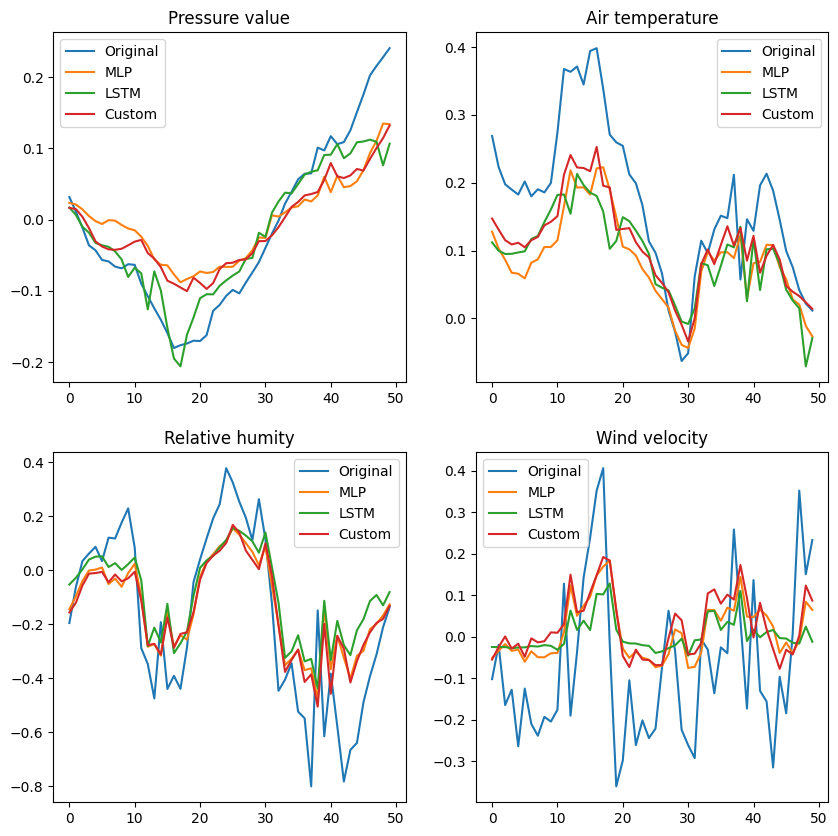

In [37]:
titles = ["Pressure value", "Air temperature", "Relative humity", "Wind velocity"]

plt.figure(figsize=(10,10))
for i, title in enumerate(titles):
  plt.subplot(2,2,i+1)
  plt.title(title)
  plt.plot(y.cpu().detach().numpy()[:, i])
  plt.plot(y_pred_mlp.cpu().detach().numpy()[:, i])
  plt.plot(y_pred_lstm.cpu().detach().numpy()[:, i])
  plt.plot(y_pred_custom.cpu().detach().numpy()[:, i])
  plt.legend(["Original", "MLP", "LSTM", "Custom"])
plt.show()